# DEMETER2 in Stan

In [1]:
import pystan
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az
from pathlib import Path
import seaborn as sns
from timeit import default_timer as timer
import warnings
import re
from notebook_modules.pystan_helpers import StanModel_cache

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15

modeling_data_dir = Path('../modeling_data')

warnings.filterwarnings(action='ignore', 
                        message='Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won\'t be used')

## Data preparation

In [2]:
modeling_data = pd.read_csv(modeling_data_dir / 'subset_modeling_data.csv')
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


## Exploratory data analysis

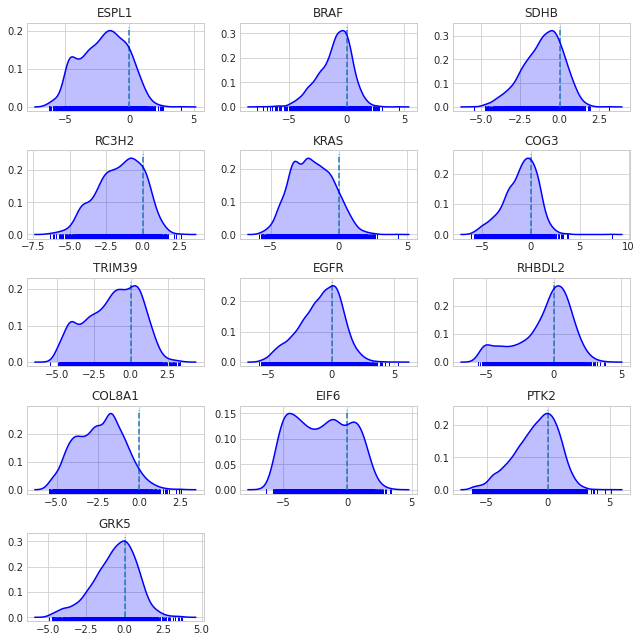

In [3]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(5, 3, figsize=(9, 9))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=False, rug=True, ax=ax, kde_kws={'shade': True}, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)


axes[4, 2].axis('off')
axes[4, 1].axis('off')
fig.tight_layout(pad=1.0)
plt.show()

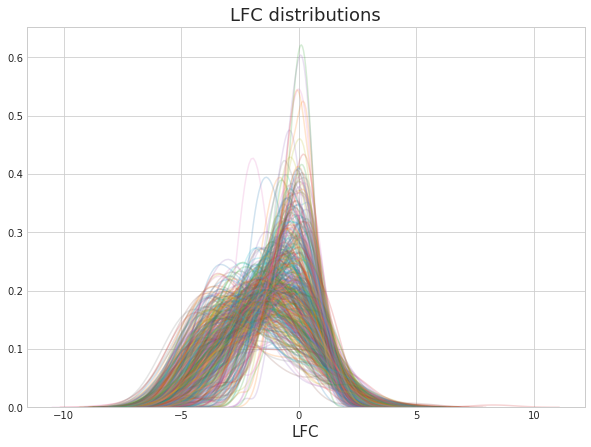

In [4]:
cell_lines = set(modeling_data.cell_line.to_list())
for cell_line in cell_lines:
    lfc = modeling_data[modeling_data.cell_line == cell_line].lfc
    sns.distplot(lfc, kde=True, hist=False, label=None, kde_kws={'alpha': 0.2})

plt.title('LFC distributions')
plt.xlabel('LFC')
plt.show()

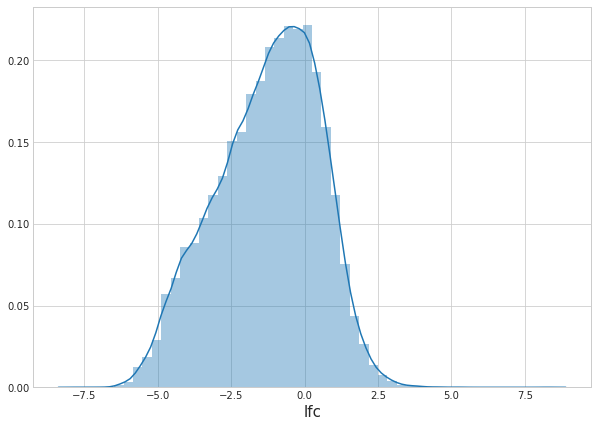

In [5]:
sns.distplot(modeling_data.lfc)
plt.show()

In [6]:
modeling_data[['barcode_sequence', 'gene_symbol']].drop_duplicates().groupby('gene_symbol').count()

,barcode_sequence
gene_symbol,
BRAF,8
COG3,5
COL8A1,5
EGFR,19
EIF6,5
ESPL1,5
GRK5,5
KRAS,11
PTK2,23


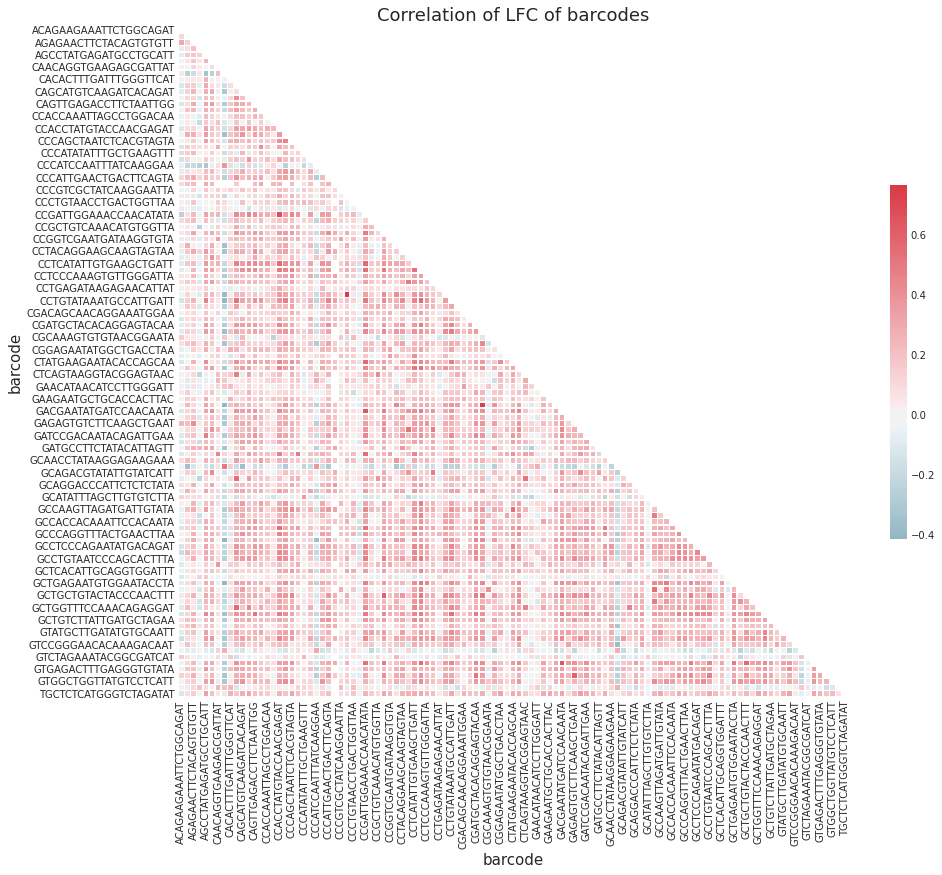

In [7]:
lfc_corr = modeling_data \
    .pivot(index='cell_line', columns='barcode_sequence', values='lfc') \
    .corr()

mask = np.triu(np.ones_like(lfc_corr, dtype=np.bool), k=0)
f, ax = plt.subplots(figsize=(15, 13))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(lfc_corr, mask=mask, 
            cmap=cmap, center=0, 
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
plt.xlabel('barcode')
plt.ylabel('barcode')
plt.title('Correlation of LFC of barcodes')
plt.show()

## Modeling

In [8]:
models_dir = Path('..', 'models')

In [9]:
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol
0,ACAGAAGAAATTCTGGCAGAT,ln215_central_nervous_system,1.966515,1,EIF6
1,ACAGAAGAAATTCTGGCAGAT,ln382_central_nervous_system,1.289606,1,EIF6
2,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6
3,ACAGAAGAAATTCTGGCAGAT,jhesoad1_oesophagus,1.392272,1,EIF6
4,ACAGAAGAAATTCTGGCAGAT,km12_large_intestine,0.820838,1,EIF6


Select only a few cell lines while model building.

In [10]:
len(np.unique(modeling_data.cell_line))

501

In [11]:
np.random.seed(123)
cell_lines = np.random.choice(np.unique(modeling_data.cell_line), 40)
modeling_data = modeling_data[modeling_data.cell_line.isin(cell_lines)]
modeling_data.shape

(3334, 5)

In [12]:
np.unique(modeling_data.gene_symbol)

array(['BRAF', 'COG3', 'COL8A1', 'EGFR', 'EIF6', 'ESPL1', 'GRK5', 'KRAS',
       'PTK2', 'RC3H2', 'RHBDL2', 'SDHB', 'TRIM39'], dtype=object)

In [13]:
# model_testing_genes = ['COG3', 'KRAS', 'COL8A1', 'EIF6']
# modeling_data = modeling_data[modeling_data.gene_symbol.isin(model_testing_genes)]

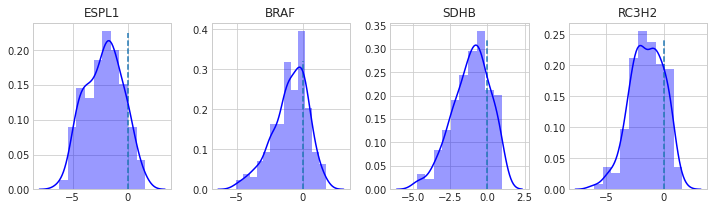

In [14]:
genes = set(modeling_data.gene_symbol.to_list())
fig, axes = plt.subplots(1, 4, figsize=(10, 3))
for ax, gene in zip(axes.flat, genes):
    lfc = modeling_data[modeling_data.gene_symbol == gene].lfc
    sns.distplot(lfc, kde=True, hist=True, ax=ax, color='b')
    
    y_data = ax.lines[0].get_ydata()
    ax.vlines(x=0, ymin=0, ymax=np.max(y_data) * 1.05, linestyles='dashed')
    
    ax.set_title(gene, fontsize=12)
    ax.set_xlabel(None)

fig.tight_layout(pad=1.0)
plt.show()

In [15]:
def add_categorical_idx(df, col):
    df[f'{col}_idx'] = df[col].astype('category').cat.codes + 1
    return df

for col in ['barcode_sequence', 'cell_line', 'gene_symbol']:
    modeling_data = add_categorical_idx(modeling_data, col)

modeling_data = modeling_data.reset_index(drop=True)
modeling_data.head()

,barcode_sequence,cell_line,lfc,batch,gene_symbol,barcode_sequence_idx,cell_line_idx,gene_symbol_idx
0,ACAGAAGAAATTCTGGCAGAT,efo21_ovary,0.625725,1,EIF6,1,11,5
1,ACAGAAGAAATTCTGGCAGAT,dbtrg05mg_central_nervous_system,2.145082,2,EIF6,1,9,5
2,ACAGAAGAAATTCTGGCAGAT,bt20_breast,0.932751,2,EIF6,1,3,5
3,ACAGAAGAAATTCTGGCAGAT,sw1783_central_nervous_system,1.372030,2,EIF6,1,36,5
4,ACAGAAGAAATTCTGGCAGAT,kns60_central_nervous_system,0.803835,2,EIF6,1,18,5


Binary matrix of $[shRNA \times gene]$.

In [16]:
shrna_gene_matrix = modeling_data[['barcode_sequence_idx', 'gene_symbol_idx']] \
    .drop_duplicates() \
    .reset_index(drop=True) \
    .assign(value = lambda df: np.ones(df.shape[0], dtype=int)) \
    .pivot(index='barcode_sequence_idx', columns='gene_symbol_idx', values='value') \
    .fillna(0) \
    .to_numpy() \
    .astype(int)

shrna_gene_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [17]:
shrna_gene_matrix.shape

(109, 13)

## Model 1. Just an intercept

$$
D \sim N(\mu, \sigma) \\
\mu = \alpha \\
\alpha \sim N(0, 5) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

**Model data.**

In [18]:
d2_m1_data = {
    'N': int(modeling_data.shape[0]),
    'y': modeling_data.lfc
}

**Compile model.**

In [19]:
d2_m1_file = models_dir / 'd2_m1.cpp'
d2_m1 = StanModel_cache(file=d2_m1_file.as_posix())

Using cached StanModel.


In [20]:
d2_m1_fit = d2_m1.sampling(data=d2_m1_data, iter=2000, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [21]:
pystan.check_hmc_diagnostics(d2_m1_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [22]:
az_d2_m1 = az.from_pystan(posterior=d2_m1_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m1)
az.summary(az_d2_m1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-1.290,0.030,-1.348,-1.234,0.001,0.001,1634.0,1634.0,1643.0,1250.0,1.0
sigma,1.737,0.021,1.698,1.775,0.000,0.000,1828.0,1827.0,1828.0,1483.0,1.0


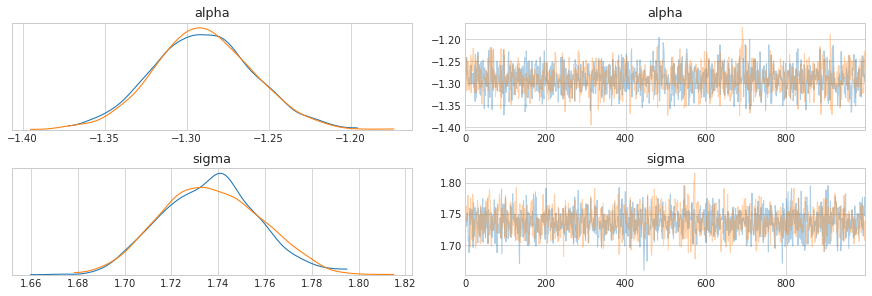

In [23]:
az.plot_trace(az_d2_m1)
plt.show()

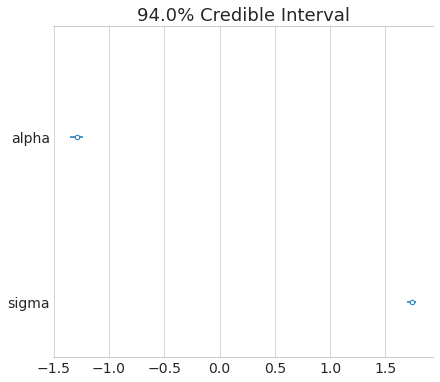

In [24]:
az.plot_forest(az_d2_m1, combined=True)
plt.show()

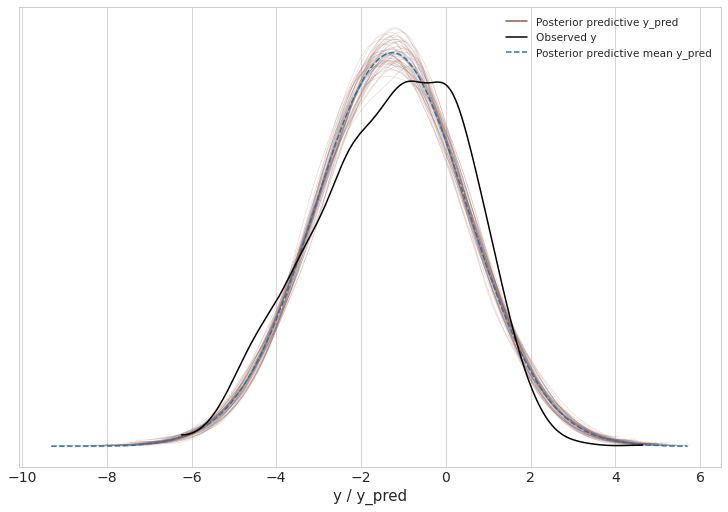

In [25]:
az.plot_ppc(az_d2_m1, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

## Model 2. Varying intercept by shRNA

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = \alpha_{i|s} \\
\alpha \sim N(\mu_{\alpha}, \sigma_{\alpha}) \\
\mu_{\alpha} \sim N(0, 2) \\
\sigma_{\alpha} \sim \text{HalfCauchy}(0, 2) \\
\sigma \sim \text{HalfCauchy}(0, 5)
$$

### Generative model for a prior predictive check

In [26]:
N = 1000
S = 100
shrna_barcodes = list(range(1, S+1))
shrna_barcodes_idx = np.repeat(shrna_barcodes, N/S)

In [27]:
d2_m2_gen_data = {
    'N': N,
    'S': S,
    'shrna': shrna_barcodes_idx
}

In [28]:
d2_m2_gen_file = models_dir / 'd2_m2_generative.cpp'
d2_m2_gen = StanModel_cache(file=d2_m2_gen_file.as_posix())

Using cached StanModel.


In [29]:
d2_m2_gen_fit = d2_m2_gen.sampling(data=d2_m2_gen_data, 
                                   iter=10, warmup=0, chains=1, 
                                   algorithm='Fixed_param')

In [30]:
az_d2_m2_gen = az.from_pystan(d2_m2_gen_fit)

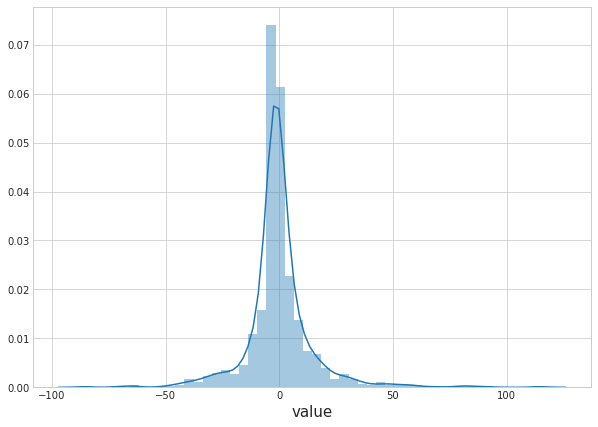

In [31]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('alpha\[')]
sns.distplot(df.value)
plt.show()

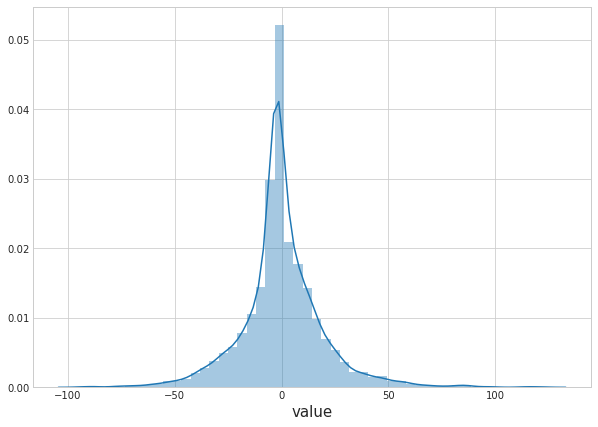

In [32]:
df = d2_m2_gen_fit.to_dataframe() \
    .drop(['chain', 'draw', 'warmup'], axis=1) \
    .melt(var_name='parameter', value_name='value')
df = df[df.parameter.str.contains('y_pred')]
sns.distplot(df.value)
plt.show()

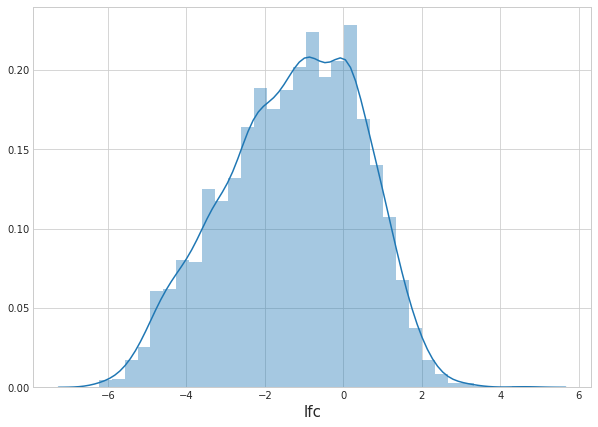

In [33]:
sns.distplot(modeling_data.lfc)
plt.show()

**Model data**

In [34]:
d2_m2_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    
    'y': modeling_data.lfc,
}

In [35]:
d2_m2_data['S']

109

**Compile model.**

In [36]:
d2_m2_file = models_dir / 'd2_m2.cpp'
d2_m2 = StanModel_cache(file=d2_m2_file.as_posix())

Using cached StanModel.


In [37]:
d2_m2_fit = d2_m2.sampling(data=d2_m2_data, iter=1000, chains=2)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [38]:
pystan.check_hmc_diagnostics(d2_m2_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

In [39]:
az_d2_m2 = az.from_pystan(posterior=d2_m2_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m2)
az.summary(az_d2_m2).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,-1.226,0.123,-1.460,-1.010,0.004,0.003,892.0,875.0,896.0,629.0,1.00
sigma_alpha,1.277,0.091,1.107,1.447,0.003,0.002,1318.0,1239.0,1363.0,788.0,1.00
alpha[0],0.723,0.201,0.298,1.065,0.006,0.004,1167.0,1146.0,1160.0,577.0,1.01
alpha[1],-0.258,0.215,-0.664,0.139,0.005,0.005,1577.0,864.0,1569.0,665.0,1.00
alpha[2],-0.781,0.203,-1.165,-0.431,0.006,0.004,1130.0,1111.0,1099.0,623.0,1.00


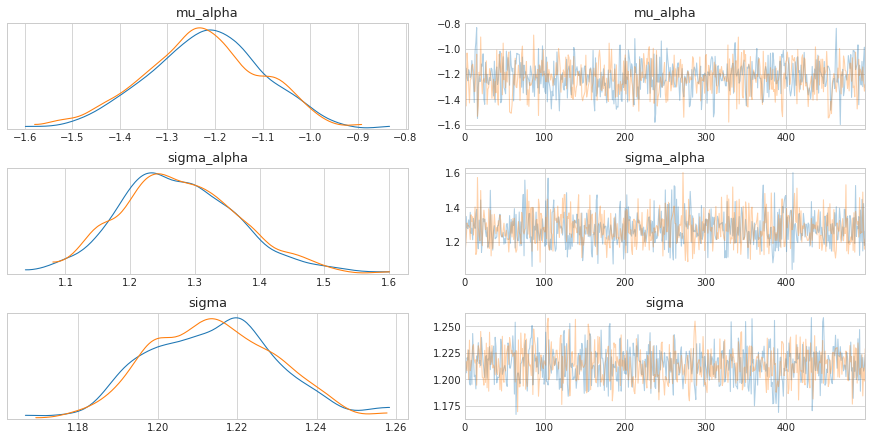

In [40]:
az.plot_trace(az_d2_m2, var_names=['mu_alpha', 'sigma_alpha', 'sigma'])
plt.show()

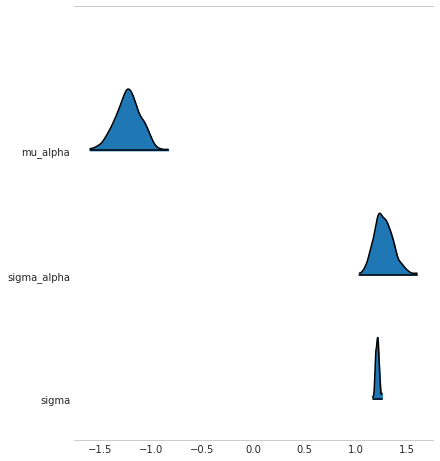

In [41]:
az.plot_forest(az_d2_m2, kind='ridgeplot', combined=True, 
               var_names=['mu_alpha', 'sigma_alpha', 'sigma'])
plt.show()

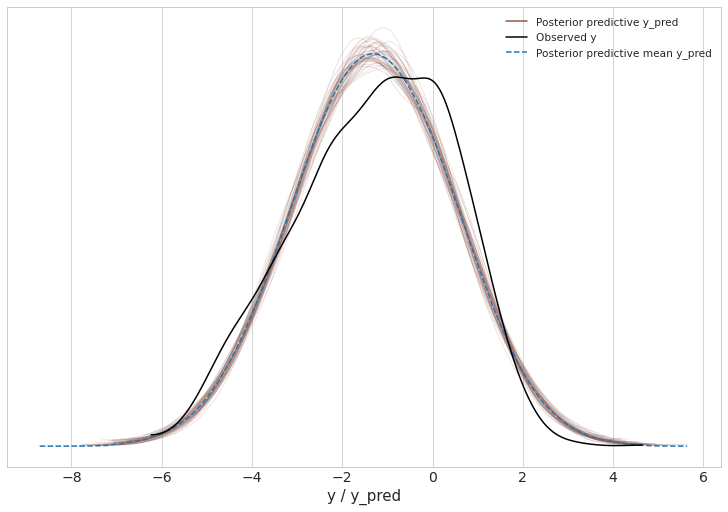

In [42]:
az.plot_ppc(az_d2_m2, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

In [43]:
d2_m2_fit.to_dataframe().head()

,chain,draw,warmup,mu_alpha,sigma_alpha,alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],...,y_pred[3332],y_pred[3333],y_pred[3334],lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,-1.217603,1.184129,0.483273,-0.227935,-0.727692,0.351354,-2.152737,...,-0.594729,1.821350,-1.631423,-2390.075773,1.000000,0.480317,3,7,0,2440.724479
1,0,1,0,-1.187599,1.168174,0.729238,-0.581836,-1.154489,0.290367,-2.251906,...,-2.440855,0.921404,0.208628,-2388.207306,0.949850,0.480317,3,7,0,2436.278127
2,0,2,0,-1.154394,1.346258,0.634884,0.110074,-0.512595,0.208157,-2.268904,...,-1.770858,-0.252139,0.043771,-2382.399034,0.870275,0.480317,3,7,0,2439.250784
3,0,3,0,-1.232713,1.281172,0.826088,-0.655137,-1.075877,0.110451,-2.292866,...,-1.541689,0.537506,-0.700493,-2388.219495,0.792273,0.480317,3,7,0,2434.015352
4,0,4,0,-1.252975,1.275426,0.653503,-0.313605,-0.565771,0.305625,-2.288373,...,-2.375068,-3.381410,0.233371,-2386.348131,0.743973,0.480317,3,7,0,2441.391342


## Model 3. Another varying intercept for target gene

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma) \\
\mu = \alpha_{i|s} + g_{i|l}\\
\alpha_s \sim N(\mu_{\alpha}, \sigma_{\alpha}) \\
g_l \sim N(\mu_g, \sigma_g) \\
\mu_{\alpha} \sim N(0, 2) \quad \sigma_{\alpha} \sim \text{HalfCauchy}(0, 10) \\
\mu_{g} \sim N(0, 2) \quad \sigma_{g} \sim \text{HalfCauchy}(0, 10) \\
\sigma \sim \text{HalfCauchy}(0, 10)
$$

In [44]:
d2_m3_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    
    'y': modeling_data.lfc,
}

**Compile model.**

In [45]:
d2_m3_file = models_dir / 'd2_m3.cpp'
d2_m3 = StanModel_cache(file=d2_m3_file.as_posix())

Using cached StanModel.


In [46]:
d2_m3_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m3_fit = d2_m3.sampling(data=d2_m3_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m3_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [47]:
pystan.check_hmc_diagnostics(d2_m3_fit)

{'n_eff': True,
 'Rhat': False,
 'divergence': False,
 'treedepth': False,
 'energy': True}

In [48]:
az_d2_m3 = az.from_pystan(posterior=d2_m3_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m3)
az.summary(az_d2_m3).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,-0.724,1.171,-2.916,1.289,0.334,0.242,12.0,12.0,12.0,75.0,1.25
sigma_alpha,1.229,0.093,1.042,1.392,0.002,0.001,2101.0,2087.0,2108.0,3051.0,1.00
mu_g,-0.571,1.172,-2.634,1.562,0.334,0.242,12.0,12.0,12.0,74.0,1.25
sigma_g,0.417,0.202,0.084,0.800,0.009,0.007,471.0,471.0,381.0,366.0,1.01
alpha[0],1.518,1.242,-0.717,3.765,0.345,0.250,13.0,13.0,13.0,77.0,1.23


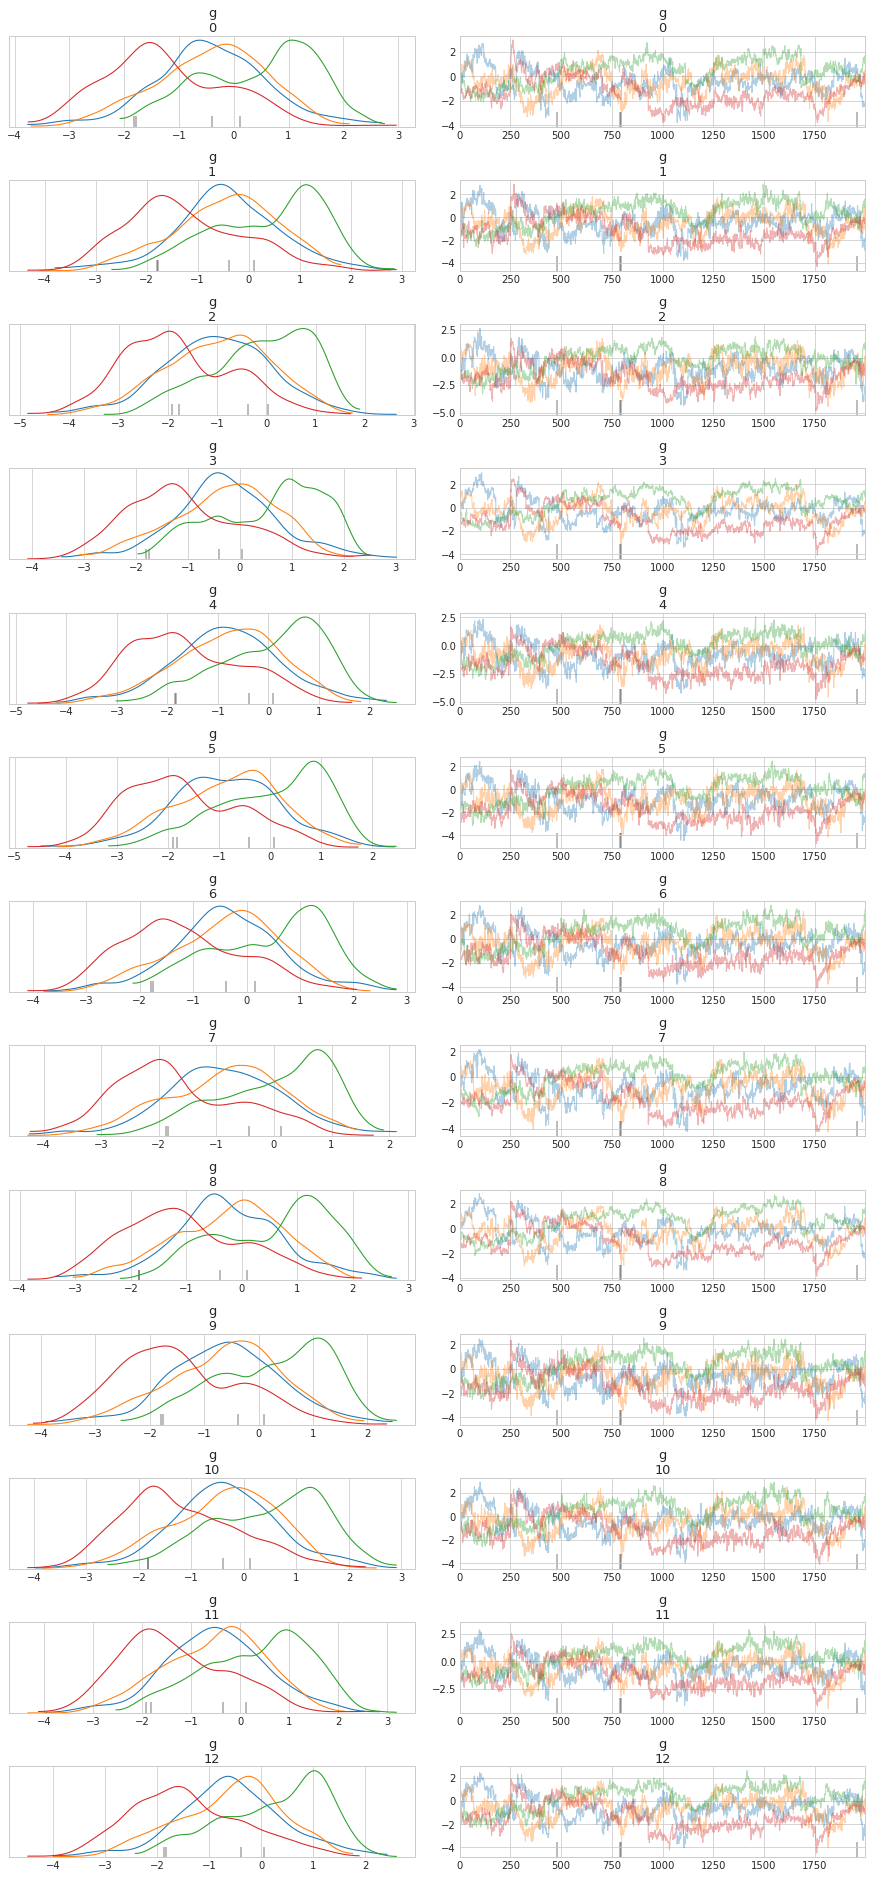

In [49]:
az.plot_trace(az_d2_m3, var_names=['g'])
plt.show()

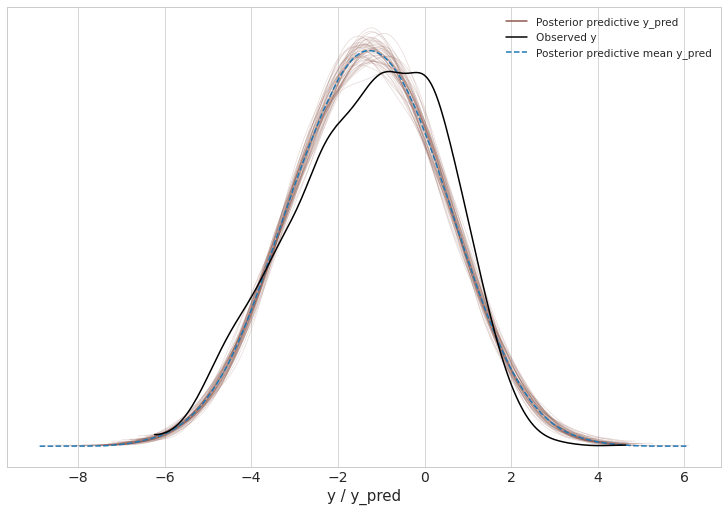

In [50]:
az.plot_ppc(az_d2_m3, data_pairs={'y':'y_pred'}, num_pp_samples=50)
plt.show()

In [51]:
fit3_summary = az.summary(az_d2_m3)

In [52]:
fit3_alpha_summary = fit3_summary[fit3_summary.index.str.contains('alpha\[')]
shrna_idx = [re.search(r"\[([A-Za-z0-9_]+)\]", a).group(1) for a in fit3_alpha_summary.index]
shrna_idx = [int(a) + 1 for a in shrna_idx]
fit3_alpha_summary = fit3_alpha_summary \
    .assign(barcode_sequence_idx = shrna_idx) \
    .set_index('barcode_sequence_idx') \
    .join(modeling_data[['barcode_sequence_idx', 'gene_symbol']] \
          .drop_duplicates() \
          .set_index('barcode_sequence_idx'))
fit3_alpha_summary.head(10)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,gene_symbol
barcode_sequence_idx,,,,,,,,,,,,
1,1.518,1.242,-0.717,3.765,0.345,0.250,13.0,13.0,13.0,77.0,1.23,EIF6
2,0.131,1.221,-2.047,2.445,0.330,0.239,14.0,14.0,14.0,93.0,1.22,GRK5
3,0.018,1.241,-2.136,2.315,0.344,0.249,13.0,13.0,13.0,75.0,1.23,EIF6
4,0.537,1.221,-1.727,2.741,0.332,0.240,13.0,13.0,14.0,86.0,1.22,EGFR
5,-1.273,1.248,-3.512,0.949,0.336,0.243,14.0,14.0,14.0,106.0,1.21,COL8A1
6,-0.646,1.216,-2.810,1.508,0.334,0.241,13.0,13.0,13.0,94.0,1.22,KRAS
7,-0.423,1.211,-2.655,1.805,0.330,0.238,14.0,14.0,14.0,76.0,1.22,PTK2
8,1.296,1.210,-0.922,3.533,0.329,0.238,14.0,14.0,14.0,68.0,1.22,PTK2
9,0.481,1.214,-1.795,2.669,0.329,0.238,14.0,14.0,14.0,66.0,1.22,PTK2


In [53]:
fit3_gene_summary = fit3_summary[fit3_summary.index.str.contains('g\[')]
gene_idx = [re.search(r"\[([A-Za-z0-9_]+)\]", a).group(1) for a in fit3_gene_summary.index]
gene_idx = [int(a) + 1 for a in gene_idx]
fit3_gene_summary = fit3_gene_summary \
    .assign(gene_symbol_idx = gene_idx) \
    .set_index('gene_symbol_idx') \
    .join(modeling_data[['gene_symbol_idx', 'gene_symbol']] \
          .drop_duplicates() \
          .set_index('gene_symbol_idx')) \
    .reset_index(drop=False)
fit3_gene_summary.head(10)

,gene_symbol_idx,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,gene_symbol
0,1,-0.417,1.207,-2.645,1.796,0.341,0.247,13.0,13.0,13.0,65.0,1.24,BRAF
1,2,-0.451,1.210,-2.670,1.724,0.334,0.242,13.0,13.0,13.0,91.0,1.23,COG3
2,3,-0.988,1.233,-3.147,1.243,0.336,0.243,14.0,14.0,14.0,102.0,1.22,COL8A1
3,4,-0.280,1.192,-2.406,1.907,0.331,0.240,13.0,13.0,13.0,77.0,1.23,EGFR
4,5,-0.810,1.227,-2.997,1.381,0.344,0.249,13.0,13.0,13.0,78.0,1.24,EIF6
5,6,-0.863,1.234,-3.117,1.284,0.343,0.249,13.0,13.0,13.0,73.0,1.23,ESPL1
6,7,-0.387,1.208,-2.667,1.770,0.331,0.239,13.0,13.0,14.0,91.0,1.22,GRK5
7,8,-0.863,1.203,-3.047,1.187,0.334,0.242,13.0,13.0,13.0,103.0,1.23,KRAS
8,9,-0.258,1.184,-2.498,1.843,0.330,0.239,13.0,13.0,13.0,63.0,1.24,PTK2
9,10,-0.621,1.216,-2.858,1.555,0.336,0.243,13.0,13.0,13.0,93.0,1.23,RC3H2


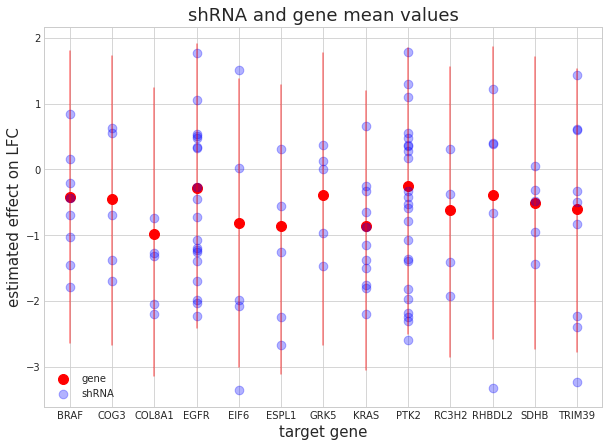

In [54]:
for i in range(fit3_gene_summary.shape[0]):
    plt.plot(np.repeat(fit3_gene_summary.loc[i, 'gene_symbol'], 2), 
             [fit3_gene_summary.loc[i, 'hpd_3%'], fit3_gene_summary.loc[i, 'hpd_97%']],
             color='red', alpha=0.5)


plt.scatter(fit3_gene_summary['gene_symbol'], 
            fit3_gene_summary['mean'],
            s=100, c='r', label='gene')
plt.scatter(fit3_alpha_summary['gene_symbol'], 
            fit3_alpha_summary['mean'], 
            alpha=0.3, s=75, c='b', label='shRNA')

plt.title('shRNA and gene mean values')
plt.xlabel('target gene')
plt.ylabel('estimated effect on LFC')
plt.legend()
plt.show()

## Model 4. Parameters for difference between average gene effect and cell line-specific effect

Note that the varying intercept for shRNA has been renamed from $\alpha$ to $c$.
$\bar g_{l}$ is the average effect of knocking-down gene $l$ while $g_{jl}$ is the cell line $j$-specific effect of knocking-down $l$.

There is now also varying population level standard deviations for each shRNA $\sigma_s$.
This seems to help reduce divergences during sampling by modeling differences in standard deviation for each shRNA.

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma_s) \\
\mu = c_{i|s} + \bar g_{i|l} + g_{i|jl} \\
c_s \sim N(0, \sigma_c) \\
\bar g_l \sim N(\mu_{\bar g}, \sigma_{\bar g}) \\
g_{jl} \sim N(0, \sigma_g) \\
\sigma_c \sim \text{HalfNormal}(0, 3) \\
\mu_{\bar g} \sim N(0, 2) \quad \sigma_{\bar g} \sim \text{HalfNormal}(0, 10) \\
\sigma_g \sim \text{HalfNormal}(0, 5) \\
\sigma_s \sim \text{HalfNormal}(\mu_\sigma, \sigma_\sigma) \\
\mu_\sigma \sim \text{HalfNormal}(0, 2) \quad \sigma_\sigma \sim \text{HalfNormal}(0, 1) \\
$$

In [55]:
d2_m4_data = {
    'N': int(modeling_data.shape[0]),
    'S': np.max(modeling_data.barcode_sequence_idx),
    'L': np.max(modeling_data.gene_symbol_idx),
    'J': np.max(modeling_data.cell_line_idx),
    
    'shrna': modeling_data.barcode_sequence_idx,
    'gene': modeling_data.gene_symbol_idx,
    'cell_line': modeling_data.cell_line_idx,
    
    'y': modeling_data.lfc,
}

**Compile model.**

**To-Do: issue with divergence.**

In [67]:
d2_m4_file = models_dir / 'd2_m4.cpp'
d2_m4 = StanModel_cache(file=d2_m4_file.as_posix())

Using cached StanModel.


In [70]:
d2_m4_control = {'adapt_delta': 0.99, 
                 'max_treedepth': 10}
d2_m4_fit = d2_m4.sampling(data=d2_m4_data, 
                           iter=3000, warmup=1000, chains=4, 
                           control=d2_m4_control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [71]:
pystan.check_hmc_diagnostics(d2_m4_fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': True,
 'energy': True}

In [72]:
az_d2_m4 = az.from_pystan(posterior=d2_m4_fit,
                          posterior_predictive='y_pred',
                          observed_data=['y'],
                          posterior_model=d2_m4)
az.summary(az_d2_m4).head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_c,1.233,0.091,1.063,1.402,0.001,0.001,5579.0,5564.0,5614.0,5393.0,1.00
mu_gbar,-1.285,0.192,-1.657,-0.931,0.005,0.004,1477.0,1477.0,1462.0,2670.0,1.00
sigma_gbar,0.431,0.215,0.029,0.790,0.008,0.006,639.0,639.0,552.0,524.0,1.01
sigma_g,0.460,0.032,0.400,0.521,0.001,0.001,2039.0,2039.0,2027.0,3658.0,1.00
c[0],2.276,0.414,1.515,3.055,0.011,0.008,1498.0,1476.0,1539.0,2684.0,1.00


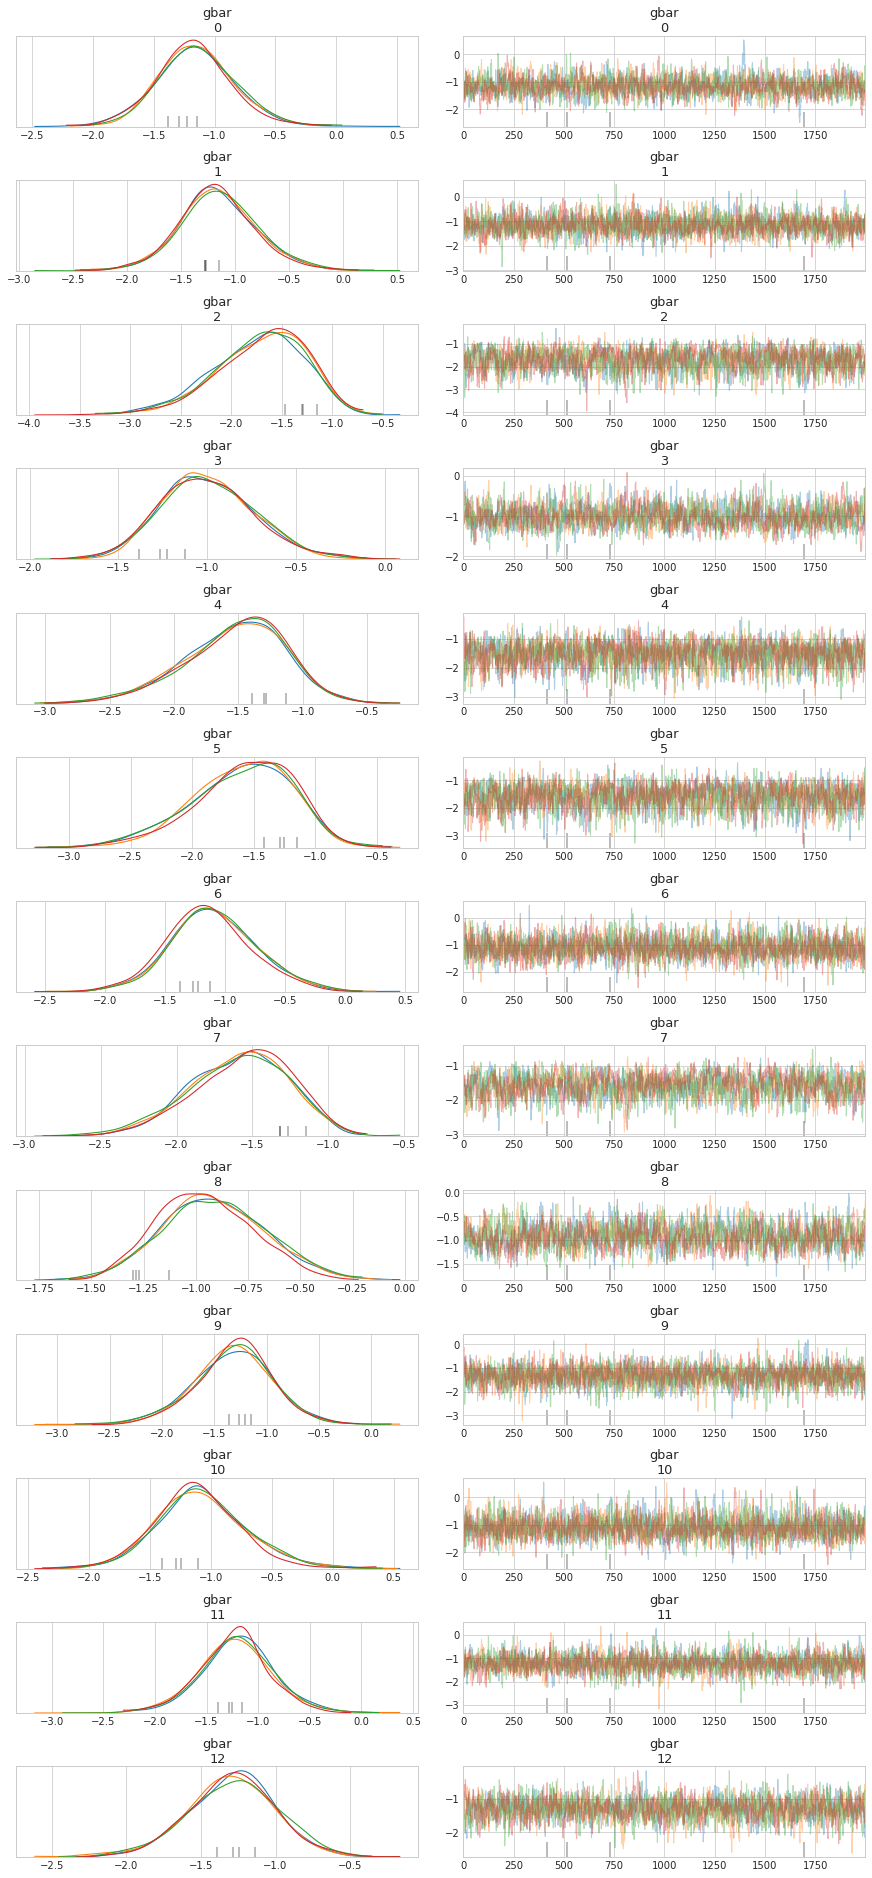

In [73]:
az.plot_trace(az_d2_m4, var_names=['gbar'])
plt.show()

In [75]:
az.summary(az_d2_m4).tail()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma[104],1.041,0.139,0.787,1.305,0.001,0.001,11473.0,11342.0,11330.0,5769.0,1.0
sigma[105],0.981,0.114,0.782,1.200,0.001,0.001,10822.0,10727.0,10730.0,5946.0,1.0
sigma[106],1.208,0.131,0.976,1.462,0.001,0.001,12932.0,12317.0,13132.0,5583.0,1.0
sigma[107],1.055,0.135,0.801,1.304,0.001,0.001,13696.0,12842.0,13926.0,6714.0,1.0
sigma[108],1.086,0.138,0.822,1.338,0.001,0.001,12787.0,11965.0,13100.0,5977.0,1.0


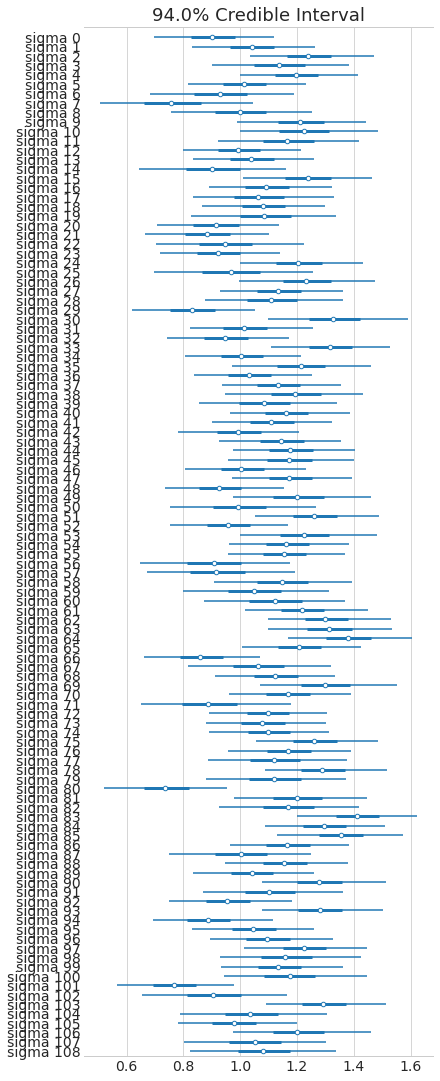

In [77]:
az.plot_forest(az_d2_m4, var_names=['sigma'], combined=True)
plt.show()

In [ ]:
az.plot_ppc(az_d2_m4, data_pairs={'y':'y_pred'}, num_pp_samples=100)
plt.show()

In [252]:
g_jl_post = d2_m4_fit.to_dataframe() \
    .melt(id_vars=['chain', 'draw', 'warmup']) \
    .pipe(lambda d: d[d.variable.str.contains('g\[')])

In [253]:
g_jl_post.head()

,chain,draw,warmup,variable,value
1008000,0,0,0,"g[1,1]",0.103903
1008001,0,1,0,"g[1,1]",0.449270
1008002,0,2,0,"g[1,1]",0.824771
1008003,0,3,0,"g[1,1]",0.491780
1008004,0,4,0,"g[1,1]",0.735416


In [260]:
def extract_g_index(s, i=0, outside_text='g[]'):
    s_mod = [a.strip(outside_text) for a in s]
    s_mod = [a.split(',') for a in s_mod]
    s_mod = [a[i].strip() for a in s_mod]
    return s_mod

In [255]:
g_jl_post = g_jl_post \
    .assign(cell_line_idx=lambda x: extract_g_index(x.variable.to_list(), i=0),
            gene_symbol_idx=lambda x: extract_g_index(x.variable.to_list(), i=1)) \
    .astype({'cell_line_idx': int, 'gene_symbol_idx': int}) \
    .groupby(['cell_line_idx', 'gene_symbol_idx']) \
    .mean() \
    .reset_index() \
    .astype({'cell_line_idx': int, 'gene_symbol_idx': int}) \
    .set_index('cell_line_idx') \
    .join(modeling_data[['cell_line', 'cell_line_idx']] \
              .drop_duplicates() \
              .astype({'cell_line_idx': int}) \
              .set_index('cell_line_idx'),
          how='left') \
    .reset_index() \
    .set_index('gene_symbol_idx') \
    .join(modeling_data[['gene_symbol', 'gene_symbol_idx']] \
              .drop_duplicates() \
              .astype({'gene_symbol_idx': int}) \
              .set_index('gene_symbol_idx'),
          how='left') \
    .reset_index() \
    .assign(gene_symbol=lambda x: [f'{a} ({b})' for a,b in zip(x.gene_symbol, x.gene_symbol_idx)],
            cell_line=lambda x: [f'{a} ({b})' for a,b in zip(x.cell_line, x.cell_line_idx)]) \
    .drop(['gene_symbol_idx', 'cell_line_idx'], axis=1) \
    .pivot(index='gene_symbol', columns='cell_line', values='value')

In [256]:
from scipy.cluster import hierarchy
from scipy.spatial import distance

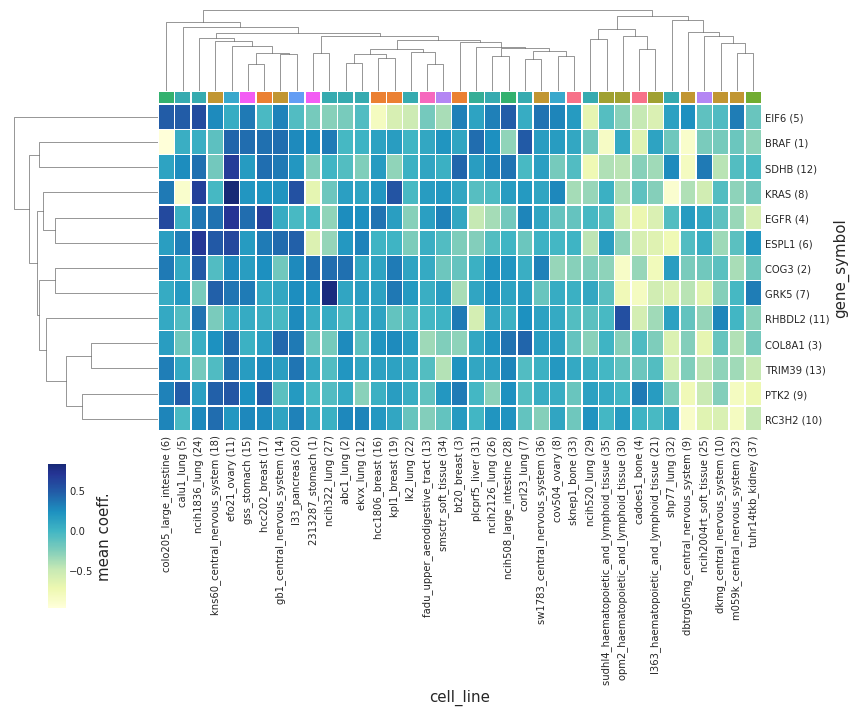

In [288]:
# Color bar for tissue of origin of cell lines.
cell_line_origin = g_jl_post.columns.to_list()
cell_line_origin = [a.split(' ')[0] for a in cell_line_origin]
cell_line_origin = [a.split('_')[1:] for a in cell_line_origin]
cell_line_origin = [' '.join(a) for a in cell_line_origin]

cell_line_pal = sns.husl_palette(len(np.unique(cell_line_origin)), s=.90)
cell_line_lut = dict(zip(np.unique(cell_line_origin), cell_line_pal))

cell_line_colors = pd.Series(cell_line_origin, index=g_jl_post.columns).map(cell_line_lut)

np.random.seed(123)
row_linkage = hierarchy.linkage(distance.pdist(g_jl_post), method='average')

p = sns.clustermap(g_jl_post, center=0, cmap="YlGnBu", linewidths=0.5, 
                   figsize=(12, 10),
                   cbar_kws={'label': 'mean coeff.'},
                   cbar_pos=[0.06, 0.15, 0.02, 0.2],
                   row_linkage=row_linkage,
                   col_colors=cell_line_colors)

In [301]:
d2_m4_post = d2_m4_fit.to_dataframe()

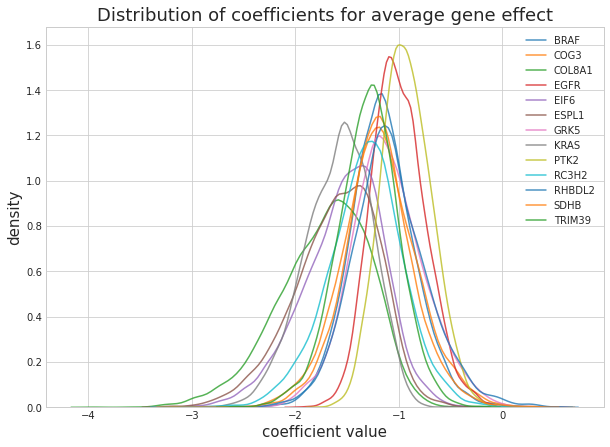

In [320]:
genes_post = d2_m4_post.loc[:, d2_m4_post.columns.str.contains('gbar\[')]

genes = list(np.unique(modeling_data.gene_symbol))
genes.sort()
genes_post.columns = genes

for col in genes_post.columns.to_list():
    sns.distplot(genes_post[[col]], hist=False, label=col, kde_kws={'shade': False, 'alpha': 0.8})

plt.legend()
plt.xlabel('coefficient value')
plt.ylabel('density')
plt.title('Distribution of coefficients for average gene effect')
plt.show()

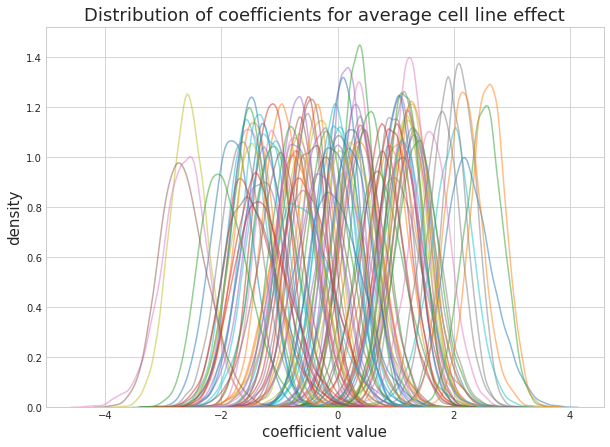

In [321]:
cell_lines_post = d2_m4_post.loc[:, d2_m4_post.columns.str.contains('c\[')]

for col in cell_lines_post.columns.to_list():
    sns.distplot(cell_lines_post[[col]], hist=False, kde_kws={'shade': False, 'alpha': 0.5})

plt.xlabel('coefficient value')
plt.ylabel('density')
plt.title('Distribution of coefficients for average cell line effect')
plt.show()

## Model 5. Varying parameter for average cell line effect of knock-down.

This model includes a parameter to estimate the cell line-specific effect of knocking down any gene.
This models the variation in response to shRNA treatment.

**Still need to adjust the model below.**

$$
D_{i|s} \sim N(\mu_{i|s}, \sigma_s) \\
\mu = c_{i|s} + \bar g_{i|l} + g_{i|jl} \\
c_s \sim N(0, \sigma_c) \\
\bar g_l \sim N(\mu_{\bar g}, \sigma_{\bar g}) \\
g_{jl} \sim N(0, \sigma_g) \\
\sigma_c \sim \text{HalfNormal}(0, 3) \\
\mu_{\bar g} \sim N(0, 2) \quad \sigma_{\bar g} \sim \text{HalfNormal}(0, 10) \\
\sigma_g \sim \text{HalfNormal}(0, 5) \\
\sigma_s \sim \text{HalfNormal}(\mu_\sigma, \sigma_\sigma) \\
\mu_\sigma \sim \text{HalfNormal}(0, 2) \quad \sigma_\sigma \sim \text{HalfNormal}(0, 1) \\
$$